# Dataset Download

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)

In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle

!mv kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jtiptj/chest-xray-pneumoniacovid19tuberculosis

100% 1.74G/1.74G [00:20<00:00, 122MB/s]
100% 1.74G/1.74G [00:20<00:00, 92.7MB/s]


In [ ]:
!unzip -q chest-xray-pneumoniacovid19tuberculosis.zip

In [ ]:
import zipfile
import os

# zip_file_path = '/content/chest-xray-pneumoniacovid19tuberculosis.zip'
# extracted_folder_path = '/content/'
# # Create a ZipFile object
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extracted_folder_path)

In [ ]:
os.remove('/content/chest-xray-pneumoniacovid19tuberculosis.zip')

# VGG

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19, DenseNet121, DenseNet169
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization


In [ ]:
# Data Preprocessing
def preprocess_data(data_path, image_size, batch_size):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        validation_split=0.2,
        preprocessing_function=lambda x: x / 255.0,
    )

    train_generator = datagen.flow_from_directory(
        data_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        color_mode='rgb'
    )

    validation_generator = datagen.flow_from_directory(
        data_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        color_mode='rgb'
    )

    return train_generator, validation_generator


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

image_size = (224, 224)

# Create the train_generator
train_generator, _ = preprocess_data('/content/train', image_size, 8)

# Process the image one at a time
for _ in range(1):  # Process only one batch
    processed_batch = train_generator.next()  # Get the processed batch
    processed_imgs = processed_batch[0]  # Extract the processed image from the batch

    plt.figure(figsize=(len(processed_imgs) * 5, 5))

    for i in range(len(processed_imgs)):
        plt.subplot(1, len(processed_imgs), i + 1)
        plt.imshow(processed_imgs[i])
        plt.title(f'Processed Image {i+1}')
        plt.axis('off')

    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/train'

In [ ]:
def create_model_with_bn_regularization(input_shape, num_classes):
    base_model = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)

    # Set all layers trainable initially
    for layer in base_model.layers:
        layer.trainable = True

    # Set only the last 5 layers trainable
    for layer in base_model.layers[:-3]:
        layer.trainable = False

    # Specific hyperparameter configuration
    activation_choice = 'tanh'
    optimizer_choice = 'sgd'
    dropout_choice = 0.3
    pooling_choice = 'avg_pooling'

    model = models.Sequential([
        base_model,
        layers.AveragePooling2D(),
        layers.GlobalAveragePooling2D(),
        BatchNormalization(),
        layers.Dense(256, activation=activation_choice, kernel_regularizer=l2(0.001)),
        layers.Dropout(dropout_choice),
        BatchNormalization(),
        layers.Dense(64, activation=activation_choice, kernel_regularizer=l2(0.001)),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model with the specified optimizer
    model.compile(optimizer=optimizer_choice, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
# Define data path and image size
data_path = '/content/train'

image_size = (224, 224)
batch_size = 16

# Preprocess the data
train_generator, validation_generator = preprocess_data(data_path, image_size, batch_size)



Found 5061 images belonging to 4 classes.
Found 1265 images belonging to 4 classes.


In [ ]:
# Define the input shape and number of classes
input_shape = (*image_size, 3)
num_classes = 4

# Create the model
model = create_model_with_bn_regularization(input_shape=(224, 224, 3), num_classes=num_classes)


# Display the model summary
model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 average_pooling2d (Average  (None, 3, 3, 512)         0         
 Pooling2D)                                                      
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               13

# Training

In [ ]:
# Model Training
def train_model(model, train_generator, validation_generator, epochs):
    callback = EarlyStopping(monitor='loss', patience=3)
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        epochs=epochs,
        callbacks=[callback]
    )
    return history

In [ ]:
# Define the number of epochs for training
epochs = 50

# Train the model
history = train_model(model, train_generator, validation_generator, epochs)

Epoch 1/50
316/316 [==============================] - 156s 463ms/step - loss: 0.9216 - accuracy: 0.8414 - val_loss: 1.0650 - val_accuracy: 0.7967
Epoch 2/50
316/316 [==============================] - 142s 449ms/step - loss: 0.6849 - accuracy: 0.9116 - val_loss: 0.7019 - val_accuracy: 0.9209
Epoch 3/50
316/316 [==============================] - 144s 454ms/step - loss: 0.6586 - accuracy: 0.9223 - val_loss: 0.6191 - val_accuracy: 0.9312
Epoch 4/50
316/316 [==============================] - 156s 493ms/step - loss: 0.6252 - accuracy: 0.9292 - val_loss: 0.6373 - val_accuracy: 0.9217
Epoch 5/50
316/316 [==============================] - 147s 465ms/step - loss: 0.5907 - accuracy: 0.9425 - val_loss: 0.6464 - val_accuracy: 0.9256
Epoch 6/50
316/316 [==============================] - 142s 448ms/step - loss: 0.5696 - accuracy: 0.9447 - val_loss: 0.6927 - val_accuracy: 0.8916
Epoch 7/50
316/316 [==============================] - 157s 498ms/step - loss: 0.5609 - accuracy: 0.9481 - val_loss: 0.5621 -

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Extract training and validation loss and accuracy from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

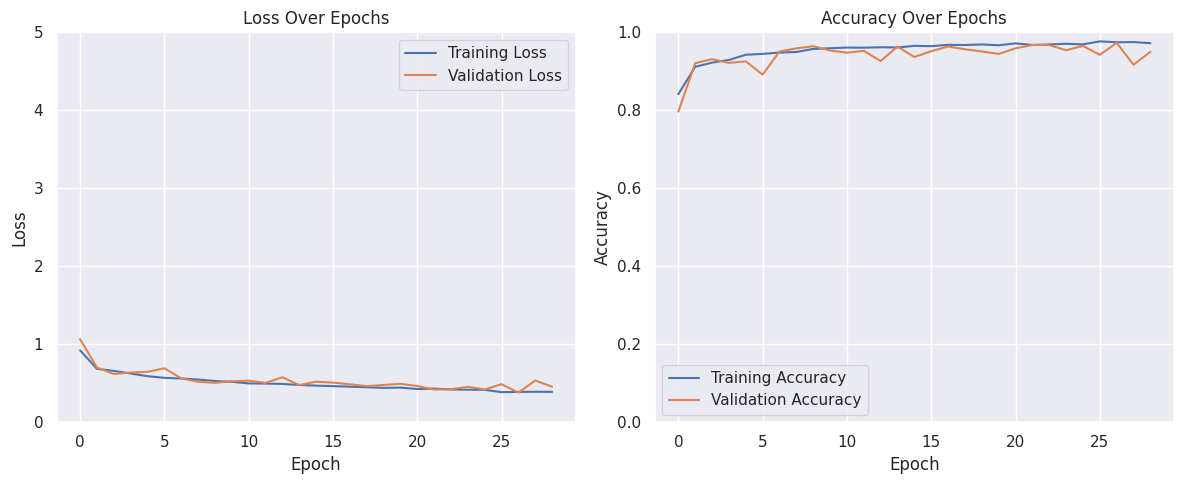

In [ ]:
# Create a figure with two subplots for loss and accuracy
sns.set()
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 5)
plt.title('Loss Over Epochs')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 1)
plt.title('Accuracy Over Epochs')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
model.save('vgg19.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Load Model (optional)

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
# Load the model from the saved file

try:
    loaded_model = load_model('/content/VGG19_hyperparameter_tuned_model_complete.h5')
except OSError as err:
    print(err)
    loaded_model=model
# loaded_model=model

No file or directory found at /content/VGG19_hyperparameter_tuned_model_complete.h5


In [ ]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 average_pooling2d (Average  (None, 3, 3, 512)         0         
 Pooling2D)                                                      
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                        

# Test

In [ ]:
# Model Evaluation
def evaluate_model(model, test_generator):
    return model.evaluate(test_generator)

In [ ]:
# Test data path (Assuming a separate test dataset)
test_data_path = '/content/test'
test_generator = ImageDataGenerator(preprocessing_function=lambda x: x / 255.0).flow_from_directory(
    test_data_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 771 images belonging to 4 classes.


In [ ]:
# Evaluate the model on the test set
test_evaluation = evaluate_model(loaded_model, test_generator)

# Display the test evaluation results
print("Test Loss:", test_evaluation[0])
print("Test Accuracy:", test_evaluation[1])

49/49 [==============================] - 12s 235ms/step - loss: 0.6742 - accuracy: 0.8781
Test Loss: 0.674233615398407
Test Accuracy: 0.878080427646637


# Prediction

In [ ]:
# Predication

import os
import random

# Specify the path to the test data folder
test_data_path = '/content/test'

# List all image files in the test_data_path folder and its subdirectories
image_files = []
for root, dirs, files in os.walk(test_data_path):
    for file in files:
        if file.endswith('.png') or file.endswith('.jpeg') or file.endswith('.jpg'):
            image_files.append([os.path.join(root, file), os.path.basename(os.path.dirname(os.path.join(root, file)))])

test_data_path = '/content/val'
for root, dirs, files in os.walk(test_data_path):
    for file in files:
        if file.endswith('.png') or file.endswith('.jpeg') or file.endswith('.jpg'):
            image_files.append([os.path.join(root, file), os.path.basename(os.path.dirname(os.path.join(root, file)))])


# image_files = image_files[:100]

In [ ]:
#Randomize the images
# random.shuffle(image_files)
# random.shuffle(image_files)
len(np.array(image_files)[:, 1])

809

In [ ]:
def transform_Image(new_image_path):
    image_size = (224, 224)
    new_image = cv2.imread(new_image_path)
    new_image = cv2.resize(new_image, image_size)
    new_image = new_image.astype(np.float32) / 255.0
    new_image = np.expand_dims(new_image, axis=0)
    return new_image

In [ ]:
y_true = []
y_predict = []

for new_image_path, true_lable in image_files:
    predictions = loaded_model.predict(transform_Image(new_image_path))
    predicted_class = np.argmax(predictions[0])
    class_labels = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']
    y_true.append(true_lable)
    y_predict.append(class_labels[predicted_class])

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, accuracy_score,precision_score, ConfusionMatrixDisplay

# confusion matrix
conf_matrix = confusion_matrix(y_true, y_predict)

# Calculate F1 score, recall, and accuracy
f1 = f1_score(y_true, y_predict, average='weighted')
recall = recall_score(y_true, y_predict, average='weighted')
accuracy = accuracy_score(y_true, y_predict)
precision = precision_score(y_true, y_predict, average="weighted")


# Display F1 score, recall, and accuracy
print("F1 Score:", f1)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("Precision:", precision)

F1 Score: 0.865497300658402
Recall: 0.8726823238566132
Accuracy: 0.8726823238566132
Precision: 0.8885235228079871


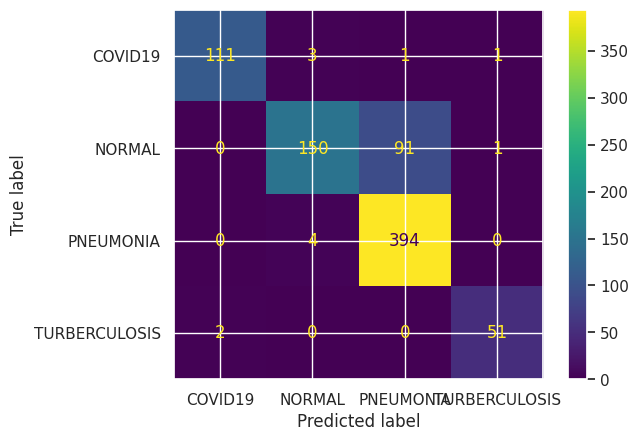

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS'])
disp.plot(cmap='viridis', values_format='d')

In [ ]:
from sklearn.metrics import classification_report

cr = classification_report(y_true, y_predict)

print(cr)

               precision    recall  f1-score   support

      COVID19       0.98      0.96      0.97       116
       NORMAL       0.96      0.62      0.75       242
    PNEUMONIA       0.81      0.99      0.89       398
TURBERCULOSIS       0.96      0.96      0.96        53

     accuracy                           0.87       809
    macro avg       0.93      0.88      0.89       809
 weighted avg       0.89      0.87      0.87       809

